# Assignment 1: Wrangling and EDA
### Foundations of Machine Learning

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `airbnb_NYC.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)


The Price variable was stored as a string because values above 999 contained commas (e.g., "1,112"), preventing numeric conversion. I removed commas and converted the column to numeric using pd.to_numeric() with errors='coerce', which converts invalid entries into NaN. The number above represents the total missing values after cleaning.

2. Categorical variable: For the Minnesota police use of for data, `mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? For the remaining missing values, replace the `np.nan/None` values with the label `Missing`.
3. Dummy variable: For `metabric.csv`, convert the `Overall Survival Status` variable into a dummy/binary variable, taking the value 0 if the patient is deceased and 1 if they are living.
4. Missing values: For `airbnb_NYC.csv`, determine how many missing values of `Review Scores Rating` there are. Create a new variable, in which you impute the median score for non-missing observations to the missing ones. Why might this bias or otherwise negatively impact your results?

In [2]:
import urllib.request
import os
import zipfile

def download_data(force=False):
    zip_path = 'data.zip'
    data_dir = './data'

    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/18235955/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")

    if not os.path.exists(data_dir) or force:
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")

    return data_dir

# ACTUALLY CALL THE FUNCTION
data_dir = download_data()
print("Data directory:", data_dir)


Download complete
Extracting data files...
Data extracted
Data directory: ./data


Question 1.1
The `Price` variable was stored as a string because values above 999 contained commas (e.g., "1,112"), preventing numeric conversion. I removed commas and converted the column to numeric using `pd.to_numeric(..., errors="coerce")`, which converts invalid entries into `NaN`. After cleaning, the number of missing `Price` values is 0


In [3]:
import pandas as pd
import numpy as np

df_airbnb = pd.read_csv("data/airbnb_NYC.csv", encoding="latin1")

# Remove commas and convert to numeric
df_airbnb["Price"] = (
    df_airbnb["Price"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df_airbnb["Price"] = pd.to_numeric(df_airbnb["Price"], errors="coerce")

# Count missing values
df_airbnb["Price"].isna().sum()



np.int64(0)

Question 1.2
I cleaned the `subject_injury` variable by stripping whitespace and treating blank or invalid strings as missing values. The proportion of missing values is 0.762. Cross-tabulation with `force_type` suggests that missingness appears more frequently in certain force categories, indicating it may not be completely random. I then replaced remaining missing values with the explicit label "Missing".


In [4]:
df_police = pd.read_csv("data/mn_police_use_of_force.csv", encoding="latin1")

# Clean whitespace
df_police["subject_injury"] = df_police["subject_injury"].astype(str).str.strip()

# Treat "nan" strings and empty strings as missing
df_police.loc[
    df_police["subject_injury"].isin(["nan", "", "None"]),
    "subject_injury"
] = np.nan

df_police["subject_injury"].head()

missing_proportion = df_police["subject_injury"].isna().mean()
missing_proportion


np.float64(0.7619342359767892)

In [5]:
pd.crosstab(
    df_police["subject_injury"],
    df_police["force_type"],
    dropna=False
)

pd.crosstab(
    df_police["subject_injury"],
    df_police["force_type"],
    normalize="columns",
    dropna=False
)

df_police["subject_injury"] = df_police["subject_injury"].fillna("Missing")

df_police["subject_injury"].value_counts()



,count
subject_injury,
Missing,9848
Yes,1631
No,1446


Question 1.3: I converted `Overall Survival Status` into a binary variable called `Overall_Survival_Binary`, where 0 indicates the patient is deceased and 1 indicates the patient is living. This transformation allows the variable to be used directly in statistical modeling as a numeric outcome.

In [6]:
df_meta = pd.read_csv("data/metabric.csv", encoding="latin1")

df_meta["Overall_Survival_Binary"] = df_meta["Overall Survival Status"].map({
    "Deceased": 0,
    "Living": 1
})

df_meta["Overall_Survival_Binary"].value_counts(dropna=False)

,count
Overall_Survival_Binary,
NaN,1343


Question 1.4 There are 10052 missing values in the `Review Scores Rating` variable. I created a new variable, `Review Scores Rating Imputed`, where missing values are replaced with the median rating (median = 94.0).

Median imputation may bias the results because it assumes missing ratings are typical of the dataset. If ratings are missing systematically—for example, if newer listings have no reviews—then imputing the median artificially gives them an average quality rating. This reduces variability in the data and may distort the relationship between ratings and other variables such as price.

In [7]:
rating_missing = df_airbnb["Review Scores Rating"].isna().sum()
rating_missing

rating_median = df_airbnb["Review Scores Rating"].median()

df_airbnb["Review Scores Rating Imputed"] = df_airbnb["Review Scores Rating"].fillna(rating_median)

rating_median

94.0

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks.

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work. What does work?
2. Drop any columns that do not contain data.
3. What is an observation? Carefully justify your answer, and explain how it affects your choices in cleaning and analyzing the data.
4. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
5. Clean the Age variable and make a histogram of the ages of the victims.
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Thoughts?

2.1 The shark dataset is an Excel file rather than a CSV file, so `pd.read_csv()` does not work. Instead, `pd.read_excel()` must be used to correctly load the dataset into Pandas.

In [8]:
from google.colab import files
uploaded = files.upload()

Saving GSAF5.xls to GSAF5.xls


In [9]:
import os
os.listdir()

['.config', 'data', 'data.zip', 'GSAF5.xls', 'sample_data']

In [10]:
df_shark = pd.read_excel("GSAF5.xls")
df_shark.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,29th January,2026.0,Unprovoked,Brazil,Recife,Del Chifre Beach in Olinda,Swimming,Deivson Rocha Dantas,M,13,...,Unknown bull and tiger sharks frequent the area,Kevin McMurray Trackingsharks.com: TV Globo: P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29th January,2026.0,Unprovoked,Australia,NSW,Angels Beach East Ballina,Surfing,Unnamed man,M,?,...,Unknown,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24th January,2026.0,Unprovoked,Australia,Tasmania,Cooee Beach west of Burnie,Swimming,Megan Stokes,F,?,...,1.7m Seven Gill shark,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20th January,2026.0,Unprovoked,Australia,NSW,Point Plomber North of Port Macquarie,Surfing,Paul Zvirdinas,M,39,...,Bull shark,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19th January,2026.0,Unprovoked,Australia,NSW,Dee Why,Surfing,Unknown,M,11,...,Bull shark,Andy Currie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Q2.2 I removed columns that contain no data using `dropna(axis=1, how="all")`, as they provide no information for analysis.

In [11]:
df_shark = df_shark.dropna(axis=1, how="all")
df_shark.shape

(7074, 23)

Q2.3 Each observation represents a single recorded shark attack incident. Each row corresponds to one event involving a victim, including attributes such as year, age, attack type, and fatality outcome. Recognizing that an observation is a single attack event determines how variables are cleaned and analyzed, since each transformation applies at the level of individual incidents rather than aggregated groups.

Q2.4 The `Year` variable contained non-numeric entries, so I extracted four-digit year values and converted them to numeric. The range spans from the 1800s to recent years. After filtering to attacks since 1940, the number of recorded attacks appears to increase over time. However, this trend likely reflects improved reporting and increased global population rather than purely biological changes in shark behavior.

In [12]:
# Extract 4-digit year
df_shark["Year"] = df_shark["Year"].astype(str).str.extract(r"(\d{4})")

df_shark["Year"] = pd.to_numeric(df_shark["Year"], errors="coerce")

df_shark["Year"].describe()

,Year
count,6941.000000
mean,1972.531336
std,51.059408
min,1000.000000
25%,1951.000000
50%,1988.000000
75%,2010.000000
max,2026.000000


Q2.5 The `Age` variable contained text entries, so I extracted numeric ages and converted them to numeric format. The histogram shows that victims are most concentrated among younger age groups.

<Axes: >

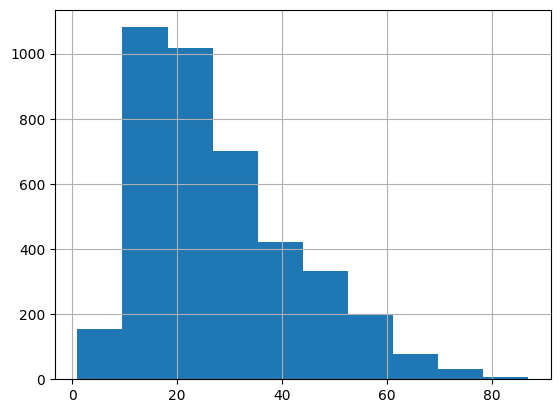

In [13]:
df_shark["Age"] = df_shark["Age"].astype(str).str.extract(r"(\d+)")
df_shark["Age"] = pd.to_numeric(df_shark["Age"], errors="coerce")

df_shark["Age"].hist()

Q2.6 I recoded the `Type` variable into three categories: Provoked, Unprovoked, and Unknown. The majority of recorded attacks are unprovoked.

In [14]:
def clean_type(x):
    if pd.isna(x):
        return "Unknown"
    x = str(x).lower()
    if "unprovoked" in x:
        return "Unprovoked"
    if "provoked" in x:
        return "Provoked"
    return "Unknown"

df_shark["Type_Clean"] = df_shark["Type"].apply(clean_type)

df_shark["Type_Clean"].value_counts(normalize=True)

,proportion
Type_Clean,
Unprovoked,0.738762
Unknown,0.170201
Provoked,0.091038


Q2.7

In [15]:
df_shark["Fatal Y/N"] = df_shark["Fatal Y/N"].astype(str).str.strip().str.upper()

df_shark["Fatal Y/N"] = df_shark["Fatal Y/N"].replace({
    "YES": "Y",
    "NO": "N"
})

df_shark["Fatal Y/N"] = df_shark["Fatal Y/N"].fillna("Unknown")

df_shark["Fatal Y/N"].value_counts()

,count
Fatal Y/N,
N,4942
Y,1489
NAN,561
UNKNOWN,71
F,5
M,3
NQ,1
2017,1
Y X 2,1


Q2.8 The cross-tabulation shows that unprovoked attacks tend to have a higher proportion of fatalities compared to provoked attacks. This may reflect differences in context, as provoked attacks often involve intentional interaction with sharks, whereas unprovoked attacks may involve unexpected encounters.

In [16]:
pd.crosstab(
    df_shark["Type_Clean"],
    df_shark["Fatal Y/N"],
    normalize="index"
)

Fatal Y/N,2017,F,M,N,NAN,NQ,UNKNOWN,Y,Y X 2
Type_Clean,,,,,,,,,
Provoked,0.001553,0.000000,0.001553,0.953416,0.006211,0.000000,0.004658,0.032609,0.000000
Unknown,0.000000,0.001661,0.000831,0.372924,0.448505,0.000000,0.009136,0.166113,0.000831
Unprovoked,0.000000,0.000574,0.000191,0.742250,0.003253,0.000191,0.010907,0.242633,0.000000


**Q3.** Open the "tidy_data.pdf" document available in `https://github.com/ds4e/wrangling`, which is a paper called *Tidy Data* by Hadley Wickham.

  1. Read the abstract. What is this paper about?
  2. Read the introduction. What is the "tidy data standard" intended to accomplish?
  3. Read the intro to section 2. What does this sentence mean: "Like families, tidy datasets are all alike but every messy dataset is messy in its own way." What does this sentence mean: "For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general."
  4. Read Section 2.2. How does Wickham define values, variables, and observations?
  5. How is "Tidy Data" defined in section 2.3?
  6. Read the intro to Section 3 and Section 3.1. What are the 5 most common problems with messy datasets? Why are the data in Table 4 messy? What is "melting" a dataset?
  7. Why, specifically, is table 11 messy but table 12 tidy and "molten"?

## Q3 – Tidy Data (Hadley Wickham)

### 3.1 What is the paper about?
The paper *Tidy Data* argues that a lot of the difficulty in data analysis doesn’t come from complex methods, but from poorly structured data. Wickham introduces a standard way of organizing datasets so they’re easier to clean, manipulate, visualize, and model.

### 3.2 What is the “tidy data standard” intended to accomplish?
The tidy data standard creates a consistent structure for datasets:
- Each variable is a column  
- Each observation is a row  
- Each type of observational unit is stored in its own table  

The goal is to make data easier to work with and compatible with analytical tools.

### 3.3 Meaning of the two sentences in Section 2
“Like families, tidy datasets are all alike but every messy dataset is messy in its own way” means that tidy datasets follow the same clear structure, but messy datasets can break those rules in many different ways. Because of that, every messy dataset often requires a different cleaning approach.

“For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general” highlights that context matters. In a specific dataset, we can usually identify rows and columns easily. But more generally, what counts as an observation or variable depends on the research question and how the data were collected.

### 3.4 Definitions of values, variables, and observations
- **Values** are individual pieces of data (like 94, “Yes,” or 2005).  
- **Variables** are attributes being measured (like age, injury status, year).  
- **Observations** are complete records of one unit (like one Airbnb listing or one shark attack).

### 3.5 How is “Tidy Data” defined in Section 2.3?
A dataset is tidy if:
- Each variable has its own column  
- Each observation has its own row  
- Each observational unit has its own table  

This structure reduces ambiguity and makes transformations predictable.

### 3.6 Five common messy data problems & melting
The five most common problems are:
1. Column headers contain values instead of variable names.  
2. Multiple variables are stored in one column.  
3. Variables are stored across multiple columns.  
4. Multiple observational units are stored in one table.  
5. One observational unit is split across multiple tables.

Table 4 is messy because values are encoded in column headers instead of being structured properly as variables.

“Melting” a dataset means converting it from wide format to long format — essentially turning column headers into values in rows. This helps restore tidy structure.

### 3.7 Why Table 11 is messy but Table 12 is tidy
Table 11 is messy because variable names are embedded in column headers, spreading information across columns.

Table 12 is tidy (and “molten”) because the data is reshaped into long format, where variable names are stored in one column and their corresponding values in another. It follows the tidy data standard.

**Q4.** This question looks at financial transfers from international actors to American universities. In particular, from which countries and giftors are the gifts coming from, and to which institutions are they going?

For this question, `.groupby([vars]).count()` and `.groupby([vars]).sum()` will be especially useful to tally the number of occurrences and sum the values of those occurrences.

1. Load the `ForeignGifts_edu.csv` dataset.
2. For `Foreign Gift Amount`, create a histogram and describe the variable. Describe your findings.
3. For `Gift Type`, create a histogram or value counts table. What proportion of the gifts are contracts, real estate, and monetary gifts?
4. What are the top 15 countries in terms of the number of gifts? What are the top 15 countries in terms of the amount given?
5. What are the top 15 institutions in terms of the total amount of money they receive? Make a histogram of the total amount received by all institutions.
6. Which giftors provide the most money, in total?

In [18]:
from google.colab import files
uploaded = files.upload()

Saving ForeignGifts_edu.xlsx to ForeignGifts_edu.xlsx


Q4.1

In [28]:
import pandas as pd

df_raw = pd.read_excel("ForeignGifts_edu.xlsx", skiprows=4, header=None)

df = df_raw.rename(columns={
    0: "OPE_ID",
    1: "Institution_Name",
    2: "Institution_State",
    3: "Gift_Type",
    5: "Country",
    6: "Foreign_Gift_Amount",
    7: "Date_1",
    8: "Date_2",
    9: "Date_3"
})

df = df[["OPE_ID", "Institution_Name", "Institution_State", "Gift_Type",
         "Country", "Foreign_Gift_Amount", "Date_1", "Date_2", "Date_3"]]

df["Foreign_Gift_Amount"] = pd.to_numeric(df["Foreign_Gift_Amount"], errors="coerce")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117150 entries, 0 to 117149
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   OPE_ID               117150 non-null  int64         
 1   Institution_Name     117150 non-null  object        
 2   Institution_State    117147 non-null  object        
 3   Gift_Type            117150 non-null  object        
 4   Country              117150 non-null  object        
 5   Foreign_Gift_Amount  117148 non-null  float64       
 6   Date_1               64605 non-null   datetime64[ns]
 7   Date_2               81146 non-null   object        
 8   Date_3               79953 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 8.0+ MB


Q4.2 - The distribution of Foreign_Gift_Amount is highly right-skewed. Most foreign gifts are relatively small, while a small number of extremely large gifts create a long right tail. The mean is significantly larger than the median, indicating the presence of large outliers. This suggests that foreign funding is concentrated in a relatively small number of high-value transactions.

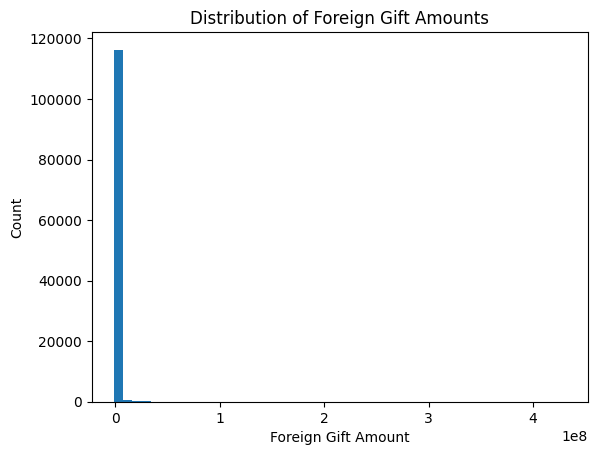

,Foreign_Gift_Amount
count,1.171480e+05
mean,5.326572e+05
std,3.959070e+06
min,-5.377700e+05
25%,7.013000e+03
50%,7.874050e+04
75%,3.500000e+05
max,4.308510e+08


In [31]:
import matplotlib.pyplot as plt
import numpy as np


amounts = df["Foreign_Gift_Amount"].dropna()

plt.figure()
plt.hist(amounts, bins=50)
plt.xlabel("Foreign Gift Amount")
plt.ylabel("Count")
plt.title("Distribution of Foreign Gift Amounts")
plt.show()


amounts.describe()

Q4.3 - The majority of foreign contributions are contracts, accounting for approximately 68.4% of all transactions when combining both standard and restricted contracts. Monetary gifts (including restricted gifts) represent about 31.6% of transactions. Real estate transfers are extremely rare, comprising only about 0.01% of all transactions.

This suggests that foreign financial involvement with U.S. institutions is overwhelmingly structured through contractual agreements rather than direct property transfers, with real estate contributions being virtually negligible.

In [38]:

gift_counts = df["Gift_Type"].value_counts()

gift_proportions = df["Gift_Type"].value_counts(normalize=True)

contract_prop, gift_prop, real_estate_prop

gift_counts
gift_proportions

,proportion
Gift_Type,
Contract,0.589834
Gift,0.270030
Restricted Contract,0.094144
Restricted Gift,0.045856
Real Estate,0.000137


Q4.4 - When ranked by number of transactions, the most frequent contributing countries are England (11,895 transactions), Canada (10,302), and Switzerland (9,453), followed by Japan and Saudi Arabia. This indicates that several Western and allied nations engage very consistently in financial exchanges with U.S. institutions.

However, when ranked by total dollar amount contributed, the ordering changes significantly. Qatar provides the largest total funding at approximately $6.57 billion, followed by Germany ($4.44 billion), England ($4.29 billion), and China ($4.06 billion).

This contrast shows that frequency of transactions does not necessarily correspond to total monetary contribution. Some countries, such as England and Canada, engage in many transactions that are individually smaller, while countries like Qatar provide fewer but substantially larger financial transfers.

In [40]:
# Top 15 countries by number of transactions
top_countries_count = (
    df["Country"]
    .value_counts()
    .head(15)
)

top_countries_count



,count
Country,
ENGLAND,11895
CANADA,10302
SWITZERLAND,9453
JAPAN,8199
SAUDI ARABIA,7890
GERMANY,7022
CHINA,6818
FRANCE,5428
SOUTH KOREA,4811


In [41]:
# Top 15 countries by total dollar amount
top_countries_amount = (
    df.groupby("Country")["Foreign_Gift_Amount"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)

top_countries_amount

,Foreign_Gift_Amount
Country,
QATAR,6.572558e+09
GERMANY,4.444384e+09
ENGLAND,4.290150e+09
CHINA,4.055471e+09
CANADA,3.961789e+09
SAUDI ARABIA,3.916048e+09
SWITZERLAND,3.392721e+09
JAPAN,3.350892e+09
HONG KONG,1.928026e+09


Q4.5 - The institutions receiving the most total foreign funding are highly concentrated among elite private research universities.

Harvard University ranks first with approximately $4.01 billion in total foreign contributions, followed by Cornell University ($3.04 billion) and Carnegie Mellon University ($2.91 billion). Other major recipients include the University of Pennsylvania, MIT, Stanford University, and Johns Hopkins University.

The distribution of total funding across institutions is heavily right-skewed. While a small number of top universities receive billions in foreign funding, the majority of institutions receive substantially smaller amounts. This suggests that foreign financial transfers to U.S. higher education are concentrated among a limited set of prestigious and research-intensive universities rather than evenly distributed across institutions.

In [42]:
# Total amount received by each institution
institution_totals = (
    df.groupby("Institution_Name")["Foreign_Gift_Amount"]
      .sum()
      .sort_values(ascending=False)
)

# Top 15 institutions
top_institutions = institution_totals.head(15)

top_institutions

,Foreign_Gift_Amount
Institution_Name,
Harvard University,4.007179e+09
Cornell University,3.043851e+09
Carnegie Mellon University,2.910470e+09
University of Pennsylvania,2.660605e+09
Massachusetts Institute of Technology,2.559417e+09
Stanford University,2.089014e+09
Johns Hopkins University,1.554340e+09
Yale University,1.521548e+09
Georgetown University,1.346672e+09


In [43]:
# Total amount received by each institution
institution_totals = (
    df.groupby("Institution_Name")["Foreign_Gift_Amount"]
      .sum()
      .sort_values(ascending=False)
)

# Top 15 institutions
top_institutions = institution_totals.head(15)

top_institutions

,Foreign_Gift_Amount
Institution_Name,
Harvard University,4.007179e+09
Cornell University,3.043851e+09
Carnegie Mellon University,2.910470e+09
University of Pennsylvania,2.660605e+09
Massachusetts Institute of Technology,2.559417e+09
Stanford University,2.089014e+09
Johns Hopkins University,1.554340e+09
Yale University,1.521548e+09
Georgetown University,1.346672e+09


Q4.6 - When aggregating total foreign contributions by country, a small number of countries account for a disproportionately large share of funding.

Qatar ranks first, providing approximately $6.57 billion in total contributions. Germany, England, China, Canada, and Saudi Arabia also contribute several billion dollars each.

The distribution of foreign funding by country is highly concentrated. While many countries provide contributions to U.S. institutions, the majority of total funding comes from a relatively small number of major international actors. This suggests that foreign financial influence in U.S. higher education is driven primarily by a limited set of countries rather than evenly dispersed globally.

In [46]:
top_gifters = (
    df.groupby("Country")["Foreign_Gift_Amount"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)

top_gifters

,Foreign_Gift_Amount
Country,
QATAR,6.572558e+09
GERMANY,4.444384e+09
ENGLAND,4.290150e+09
CHINA,4.055471e+09
CANADA,3.961789e+09
SAUDI ARABIA,3.916048e+09
SWITZERLAND,3.392721e+09
JAPAN,3.350892e+09
HONG KONG,1.928026e+09


**Q5.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `college_completion.csv` dataset from the US Department of Education. The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `college_completion.csv` data with Pandas.
2. How many observations and variables are in the data? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see in words.
4. For `grad_100_value`, create a kernel density plot and describe table. Now condition on `control`, and produce a kernel density plot and describe tables for each type of institutional control. Which type of institution appear to have the most favorable graduation rates?
5. Make a scatterplot of `grad_100_value` by `aid_value`, and compute the covariance and correlation between the two variables. Describe what you see. Now make the same plot and statistics, but conditioning on `control`. Describe what you see. For which kinds of institutions does aid seem to vary positively with graduation rates?

In [56]:
from google.colab import files
uploaded = files.upload()

Saving college_completion.csv to college_completion.csv


Q5.1

In [57]:
import pandas as pd

college = pd.read_csv("college_completion.csv")

college.head()

,ReportYear,FiceCode,Institution,CohortYear4yr,CohortCount4yr,GradRate4yr,CohortYear5yr,CohortCount5yr,GradRate5yr,CohortYear6yr,CohortCount6yr,GradRate6yr
0,2021,3541,Angelo State University,2017,1368,0.3,2016,1452,0.4,2015,1336.0,0.5
1,2021,3581,Lamar University,2017,1447,0.2,2016,1457,0.3,2015,1505.0,0.4
2,2021,3592,Midwestern State University,2017,814,0.3,2016,728,0.4,2015,818.0,0.5
3,2021,3630,Prairie View A&M University,2017,2047,0.2,2016,1834,0.4,2015,1614.0,0.5
4,2021,3606,Sam Houston State University,2017,2780,0.4,2016,2667,0.6,2015,2514.0,0.6


Q5.2 - The dataset contains 105 observations (institutions) and 12 variables.

The variables include reporting year information, institutional identifiers, cohort sizes, and graduation rates measured at 4-year, 5-year, and 6-year completion intervals. The key variable for analysis will be GradRate4yr, representing graduation within 100% of expected time for 4-year institutions.

In [58]:
n_obs, n_vars = college.shape
print("Observations (rows):", n_obs)
print("Variables (columns):", n_vars)

college.info()

Observations (rows): 105
Variables (columns): 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ReportYear      105 non-null    int64  
 1   FiceCode        105 non-null    int64  
 2   Institution     105 non-null    object 
 3   CohortYear4yr   105 non-null    int64  
 4   CohortCount4yr  105 non-null    int64  
 5   GradRate4yr     105 non-null    float64
 6   CohortYear5yr   105 non-null    int64  
 7   CohortCount5yr  105 non-null    int64  
 8   GradRate5yr     105 non-null    float64
 9   CohortYear6yr   105 non-null    int64  
 10  CohortCount6yr  104 non-null    float64
 11  GradRate6yr     104 non-null    float64
dtypes: float64(4), int64(7), object(1)
memory usage: 10.0+ KB


5.3 - The distribution of 4-year graduation rates is right-skewed. Most institutions cluster between approximately 25% and 45%, with the highest density around 30–35%. There are relatively few institutions with very high graduation rates above 60%, which creates a right tail in the distribution. This indicates that while most schools have moderate completion rates, a smaller group of institutions perform substantially better.

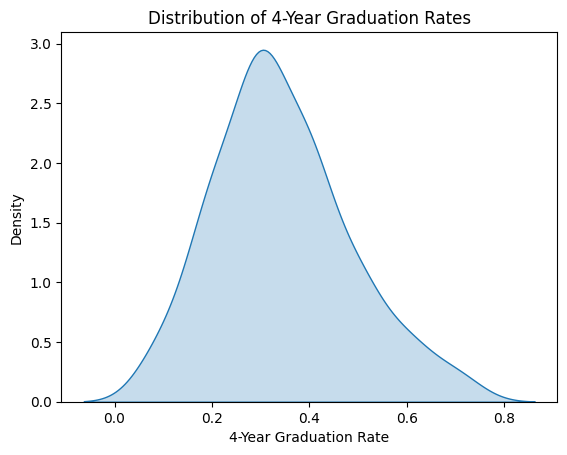

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.kdeplot(college["GradRate4yr"], fill=True)
plt.title("Distribution of 4-Year Graduation Rates")
plt.xlabel("4-Year Graduation Rate")
plt.show()

5.4 - The distribution of graduation rates shifts progressively to the right as the time horizon increases. The 4-year graduation rate is centered around lower completion percentages, while the 5-year and 6-year rates are noticeably higher.

The 5-year distribution indicates a substantial increase in completion compared to the 4-year measure. The 6-year distribution is the highest overall, with the density centered further right.

This pattern suggests that many students require more than four years to complete their degree. Therefore, evaluating institutions solely on 4-year graduation rates may underestimate overall completion performance.

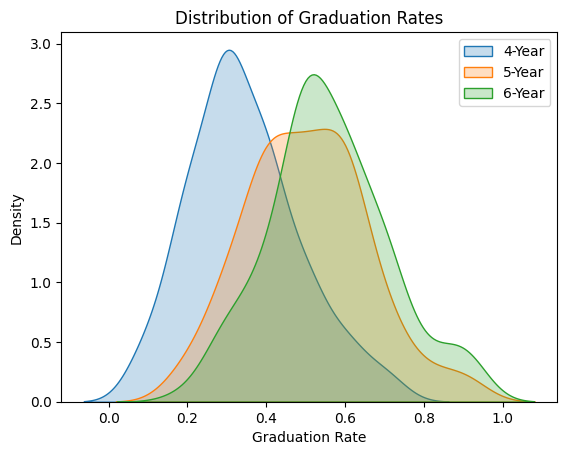

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.kdeplot(college["GradRate4yr"], label="4-Year", fill=True)
sns.kdeplot(college["GradRate5yr"], label="5-Year", fill=True)
sns.kdeplot(college["GradRate6yr"], label="6-Year", fill=True)

plt.title("Distribution of Graduation Rates")
plt.xlabel("Graduation Rate")
plt.legend()
plt.show()

Q5.5 - The scatterplot of 4-year versus 6-year graduation rates shows a strong positive linear relationship. Institutions with higher 4-year graduation rates also tend to have higher 6-year graduation rates.

The covariance between the two variables is positive, indicating that they move together. The correlation coefficient is high and positive, demonstrating a strong linear association between early and extended completion measures.

This suggests that institutions that perform well in timely graduation also tend to maintain strong overall completion outcomes over longer time horizons.

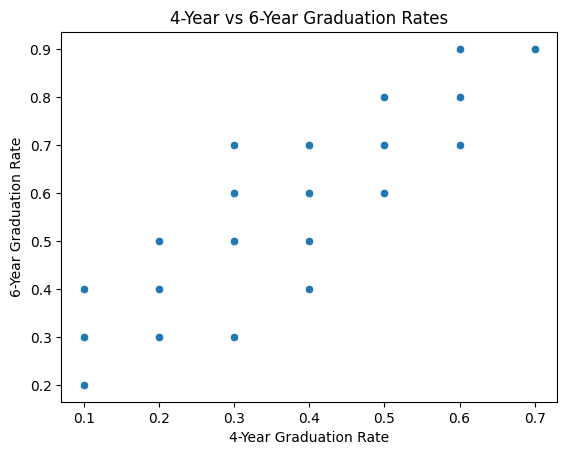

In [61]:
plt.figure()
sns.scatterplot(x=college["GradRate4yr"],
                y=college["GradRate6yr"])

plt.title("4-Year vs 6-Year Graduation Rates")
plt.xlabel("4-Year Graduation Rate")
plt.ylabel("6-Year Graduation Rate")
plt.show()

**Q6.** In class, we talked about how to compute the sample mean of a variable $X$,
$$
m(X) = \dfrac{1}{N} \sum_{i=1}^N x_i
$$
and sample covariance of two variables $X$ and $Y$,
$$
\text{cov}(X,Y) = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))(y_i - m(Y))).
$$
Recall, the sample variance of $X$ is
$$
s^2 = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))^2.
$$
It can be very helpful to understand some basic properties of these statistics. If you want to write your calculations on a piece of paper, take a photo, and upload that to your GitHub repo, that's probably easiest.

We're going to look at **linear transformations** of $X$, $Y = a + bX$. So we take each value of $X$, $x_i$, and transform it as $y_i = a + b x_i$.

1. Show that $m(a + bX) = a+b \times m(X)$.
2. Show that $ \text{cov}(X,X) = s^2$.
3. Show that $\text{cov}(X,a+bY) = b \times \text{cov}(X,Y)$
4. Show that $\text{cov}(a+bX,a+bY) = b^2 \text{cov}(X,Y) $. Notice, this also means that $\text{cov}(bX, bX) = b^2 s^2$.
5. Suppose $b>0$ and let the median of $X$ be $\text{med}(X)$. Is it true that the median of $a+bX$ is equal to $a + b \times \text{med}(X)$? Is the IQR of $a + bX$ equal to $a + b \times \text{IQR}(X)$?
6. Show by example that the means of $X^2$ and $\sqrt{X}$ are generally not $(m(X))^2$ and $\sqrt{m(X)}$. So, the results we derived above really depend on the linearity of the transformation $Y = a + bX$, and transformations like $Y = X^2$ or $Y = \sqrt{X}$ will not behave in a similar way.

In [62]:
from google.colab import files
uploaded = files.upload()

Saving IMG_1569.jpeg to IMG_1569.jpeg


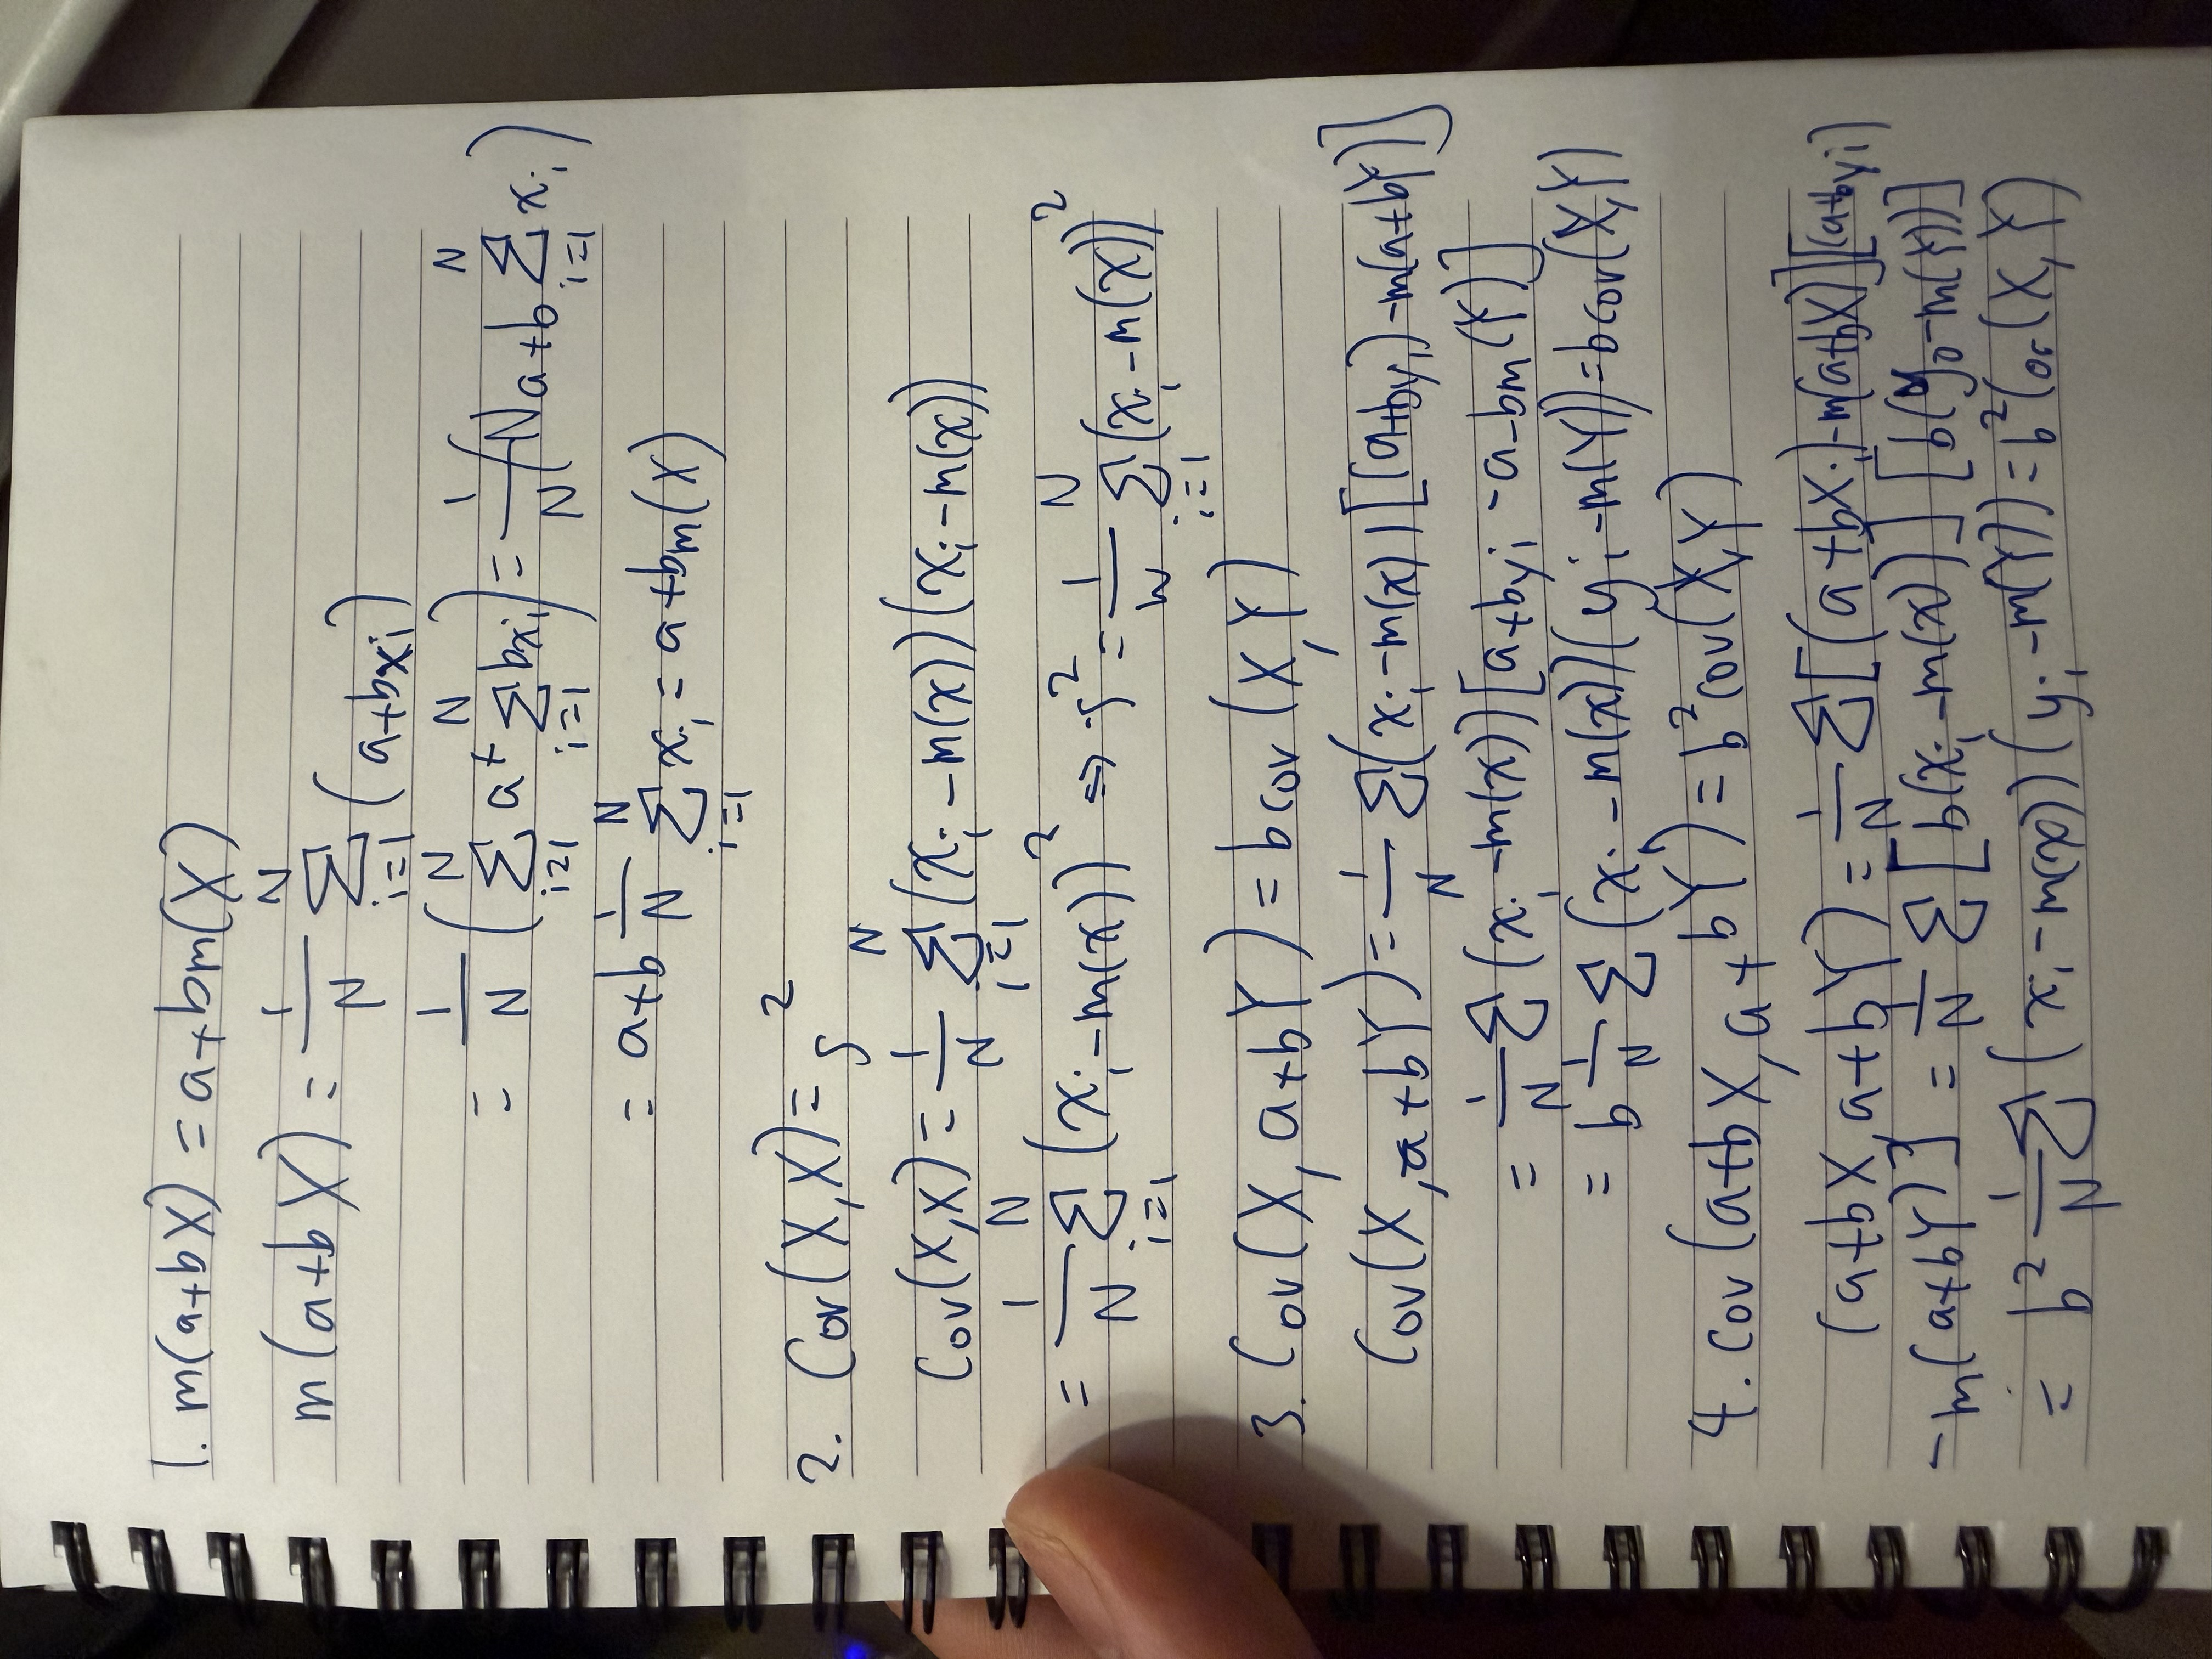

In [63]:
from IPython.display import Image, display

display(Image("IMG_1569.jpeg"))

**Q7.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `ames_prices.csv` dataset. The "relevant" variables for this question are:
  - `price` - Sale price value of the house
  - `Bldg.Type` - Building type of the house (single family home, end-of-unit townhome, duplex, interior townhome, two-family conversion)

1. Load the `college_completion.csv` data with Pandas.
2. Make a kernel density plot of price and compute a describe table. Now, make a kernel density plot of price conditional on building type, and use `.groupby()` to make a describe type for each type of building. Which building types are the most expensive, on average? Which have the highest variance in transaction prices?
3. Make an ECDF plot of price, and compute the sample minimum, .25 quantile, median, .75 quantile, and sample maximum (i.e. a 5-number summary).
4. Make a boxplot of price. Are there outliers? Make a boxplot of price conditional on building type. What patterns do you see?
5. Make a dummy variable indicating that an observation is an outlier.
6. Winsorize the price variable, and compute a new kernel density plot and describe table. How do the results change?

In [67]:
from sklearn.datasets import fetch_openml
import pandas as pd

ames = fetch_openml(name="house_prices", as_frame=True)
ames = ames.frame

ames.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [68]:
"SalePrice" in ames.columns
"BldgType" in ames.columns

True

Q7.2 - The overall distribution of house prices is strongly right-skewed, with a mean of approximately $180,921 and a median of $163,000. The large maximum value of $755,000 suggests the presence of high-value outliers that create a long right tail.

When conditioning on building type, single-family homes (1Fam) have the highest average sale price ($185,764), followed closely by end-unit townhomes (TwnhsE). Converted two-family homes (2fmCon) have the lowest average price.

Single-family homes also exhibit the highest variance in prices, indicating greater variability across that building type. Duplex properties show the lowest variance, suggesting more consistent pricing.

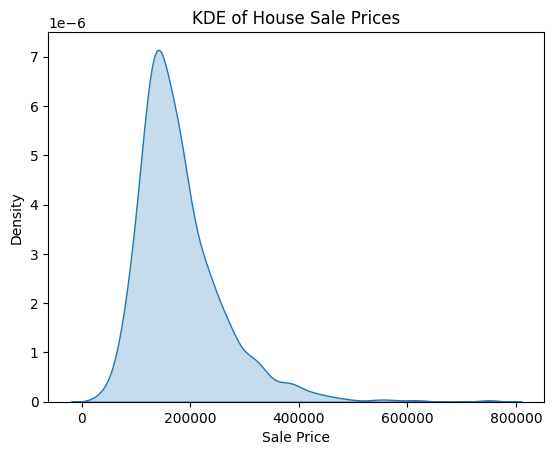

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.kdeplot(ames["SalePrice"], fill=True)
plt.title("KDE of House Sale Prices")
plt.xlabel("Sale Price")
plt.show()

ames["SalePrice"].describe()

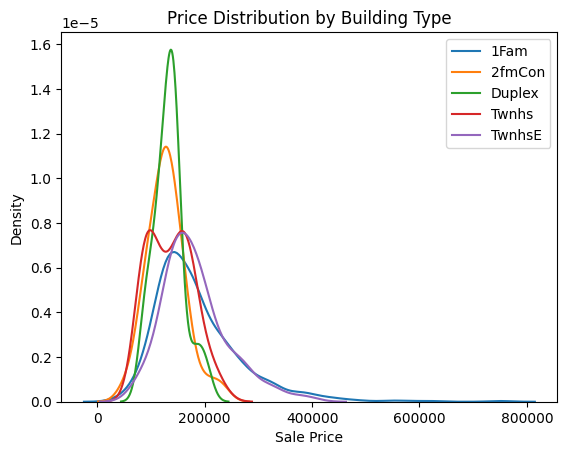

In [70]:
plt.figure()

for btype, subset in ames.groupby("BldgType"):
    sns.kdeplot(subset["SalePrice"], label=btype)

plt.title("Price Distribution by Building Type")
plt.xlabel("Sale Price")
plt.legend()
plt.show()

In [71]:
ames.groupby("BldgType")["SalePrice"].describe()

,count,mean,std,min,25%,50%,75%,max
BldgType,,,,,,,,
1Fam,1220.0,185763.807377,82648.502922,34900.0,131475.0,167900.0,222000.0,755000.0
2fmCon,31.0,128432.258065,35458.545158,55000.0,106875.0,127500.0,142500.0,228950.0
Duplex,52.0,133541.076923,27833.249197,82000.0,118375.0,135980.0,145000.0,206300.0
Twnhs,43.0,135911.627907,41013.222080,75000.0,95750.0,137500.0,168750.0,230000.0
TwnhsE,114.0,181959.342105,60626.108918,75500.0,143187.5,172200.0,207375.0,392500.0


In [72]:
ames.groupby("BldgType")["SalePrice"].mean().sort_values(ascending=False)

,SalePrice
BldgType,
1Fam,185763.807377
TwnhsE,181959.342105
Twnhs,135911.627907
Duplex,133541.076923
2fmCon,128432.258065


In [73]:
ames.groupby("BldgType")["SalePrice"].var().sort_values(ascending=False)

,SalePrice
BldgType,
1Fam,6.830775e+09
TwnhsE,3.675525e+09
Twnhs,1.682084e+09
2fmCon,1.257308e+09
Duplex,7.746898e+08


Q7.3 - The five-number summary of SalePrice shows a minimum of 34,900, a first quartile of 129,975, a median of 163,000, a third quartile of 214,000, and a maximum of 755,000. The distribution is clearly right-skewed, as the mean exceeds the median and the maximum value is substantially larger than the third quartile. Most house prices fall between approximately $130,000 and $214,000, with a small number of very expensive houses creating a long upper tail.

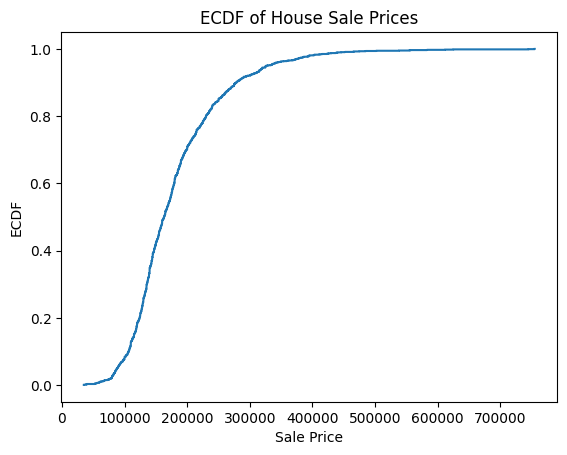

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Sort prices
x = np.sort(ames["SalePrice"])
y = np.arange(1, len(x)+1) / len(x)

plt.figure()
plt.step(x, y, where="post")
plt.xlabel("Sale Price")
plt.ylabel("ECDF")
plt.title("ECDF of House Sale Prices")
plt.show()

In [75]:
ames["SalePrice"].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


Q7.4 - The boxplot of SalePrice reveals substantial right-skewness, with numerous high-value outliers. These outliers are particularly concentrated among single-family homes (1Fam), which display both the highest median price and the greatest variability. Some single-family homes exceed $700,000, significantly extending the upper tail of the distribution.

End-unit townhomes (TwnhsE) also exhibit relatively high median prices and moderate variability, though far fewer extreme outliers than single-family homes. In contrast, duplex and converted two-family homes (2fmCon) have lower median prices and tighter distributions, indicating less price dispersion.

Overall, single-family homes are both the most expensive and the most variable building type in the dataset.

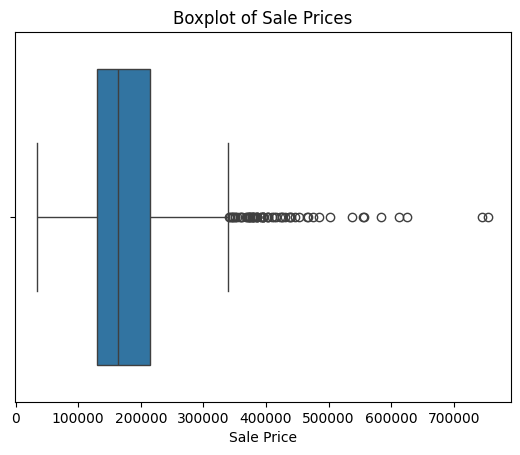

In [76]:
plt.figure()
sns.boxplot(x=ames["SalePrice"])
plt.title("Boxplot of Sale Prices")
plt.xlabel("Sale Price")
plt.show()

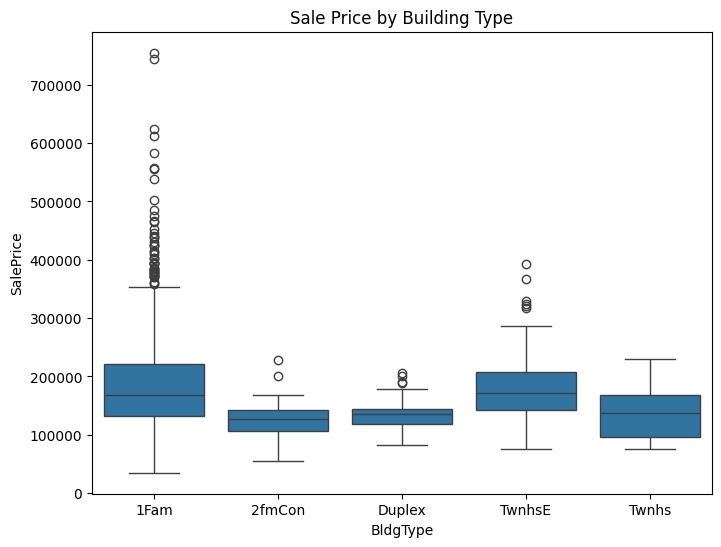

In [77]:
plt.figure(figsize=(8,6))
sns.boxplot(x="BldgType", y="SalePrice", data=ames)
plt.title("Sale Price by Building Type")
plt.show()

Q7.5 - Using the IQR rule, the lower and upper fences were calculated as 3,937.5 and 340,037.5 respectively. Since the minimum sale price exceeds the lower bound, all detected outliers occur in the upper tail. A dummy variable (price_outlier) was created that equals 1 if a property’s sale price exceeds the upper fence and 0 otherwise.

A total of 61 observations (approximately 4.2% of the dataset) were classified as outliers. This confirms that extreme values are relatively rare but concentrated among high-value homes, contributing to the pronounced right-skewness of the price distribution.

In [79]:
Q1 = ames["SalePrice"].quantile(0.25)
Q3 = ames["SalePrice"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(np.float64(3937.5), np.float64(340037.5))

In [82]:
ames["price_outlier"] = (
    (ames["SalePrice"] < lower_bound) |
    (ames["SalePrice"] > upper_bound)
).astype(int)
ames["price_outlier"].value_counts()

,count
price_outlier,
0,1399
1,61


Q7.6 - After winsorizing sale prices using the IQR upper bound of 340,037.5, the mean decreased from 180,921 to 177,332 and the standard deviation decreased substantially from 79,442 to 67,206. This indicates that a small number of high-priced homes were significantly inflating overall variability.

The median and interquartile range remained unchanged, demonstrating their robustness to extreme values. The KDE plot shows that the long right tail present in the original distribution is truncated after winsorization, confirming that skewness was primarily driven by upper-tail outliers.

In [83]:
ames["SalePrice_wins"] = ames["SalePrice"].clip(
    lower=lower_bound,
    upper=upper_bound
)

In [84]:
print("Original:")
print(ames["SalePrice"].describe())

print("\nWinsorized:")
print(ames["SalePrice_wins"].describe())

Original:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Winsorized:
count      1460.000000
mean     177331.526370
std       67205.835915
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      340037.500000
Name: SalePrice_wins, dtype: float64


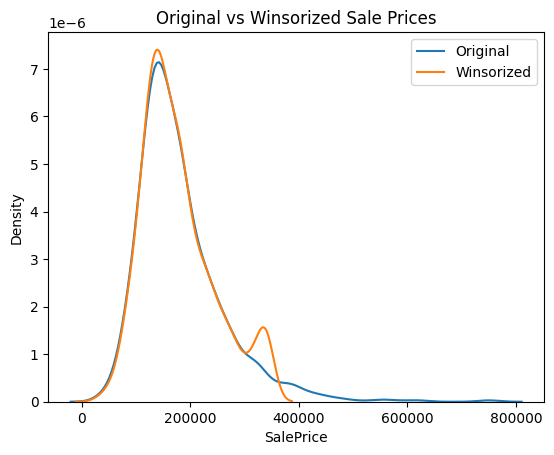

In [85]:
plt.figure()
sns.kdeplot(ames["SalePrice"], label="Original")
sns.kdeplot(ames["SalePrice_wins"], label="Winsorized")
plt.title("Original vs Winsorized Sale Prices")
plt.legend()
plt.show()